<a href="https://www.kaggle.com/code/dataranch/spotify-artist-stats-eda-model-comparison?scriptVersionId=107433506" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Spotify Artist Stats Model Comparison + Feature Importance 📊**</div>
- Preprocessing
    - Detect continuous and categorical variables.
    - Normalize and impute data.
    

- For every target variable in the dataset:
    - Compare performance on 27 models + a TabNet model.
    - Output model performance and processed data in CSV format for every dataset.
    - Save plots + CSVs of XGBoost Feature Importances.
    - Save best performing FastAI model.

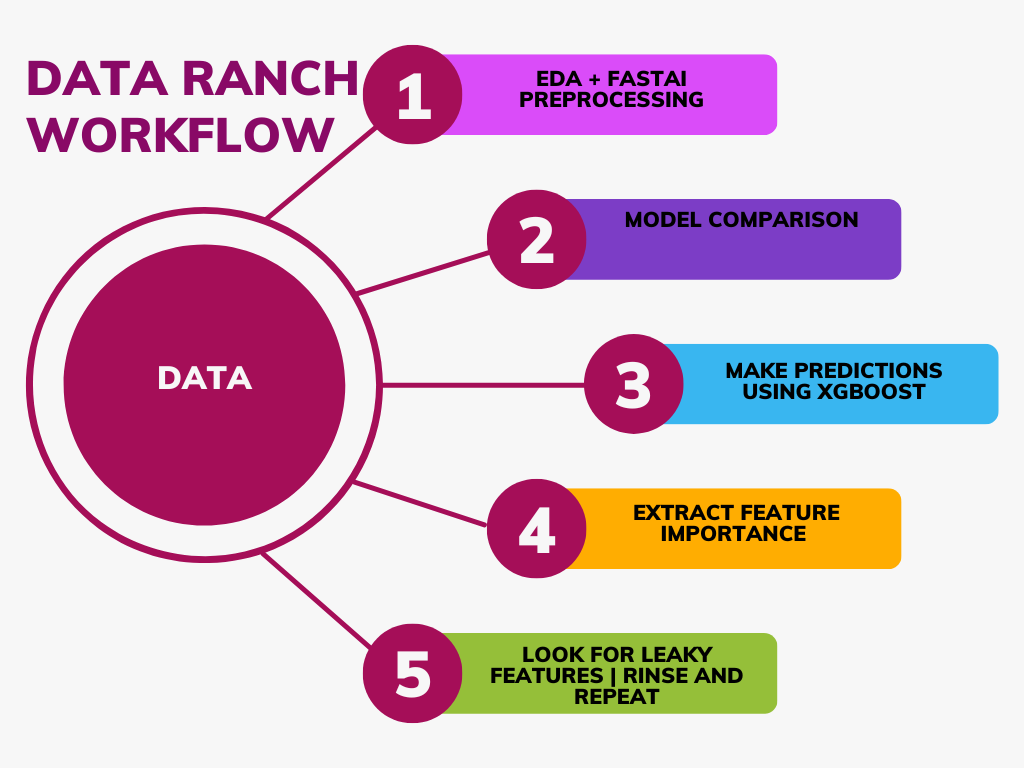

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install lazypredict

In [3]:
!pip install --upgrade pandas

In [4]:
!pip install fast-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 998.8 kB/s eta 0:00:00


In [5]:
!pip install fastai

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.0 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires te

In [6]:
!pip install pandas-profiling

  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
werkzeug 2.2.2 requires MarkupSafe>=2.1.1, but you have markupsafe 2.0.1 which is incompatible.


In [7]:
#A program that takes a csv and trains models on it. Streamlined model selection.
#==============================================================================

#LazyPredict
import lazypredict
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier
#Baysian Optimization
from bayes_opt import BayesianOptimization
#Pandas stack
import pandas as pd
import pandas_profiling
import numpy as np
#FastAI
from fastai.tabular.all import *
from fastai.tabular.core import *
#Plots
import matplotlib.pyplot as plt
import seaborn as sns
#System
import os
import sys
import traceback
#Fit an xgboost model
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
#Random
import random

#TabNet
from fast_tabnet.core import *

import shutil

In [8]:
%matplotlib inline

In [9]:
# For Styling
plt.style.use('seaborn-bright')

In [10]:
#Project Variables
#===================================================================================================
PROJECT_NAME = 'spotify-artist-stats'
VARIABLE_FILES = False
#Maximum amount of rows to take
SAMPLE_COUNT = 20000
FASTAI_LEARNING_RATE = 1e-1
AUTO_ADJUST_LEARNING_RATE = False
#Set to True automatically infer if variables are categorical or continuous
ENABLE_BREAKPOINT = True
#When trying to declare a column a continuous variable, if it fails, convert it to a categorical variable
CONVERT_TO_CAT = False
REGRESSOR = True
SEP_DOLLAR = False
SEP_COMMA = True
SHUFFLE_DATA = True

In [11]:
input_dir = f'../input/{PROJECT_NAME}'
param_dir = f'/kaggle/working/{PROJECT_NAME}'
TARGET = ''
PARAM_DIR = param_dir
print(f'param_dir: {param_dir}')
if not os.path.exists(param_dir):
    os.makedirs(param_dir)
#rename any file in param_dir/file that ends with csv to data.csv
for file in os.listdir(input_dir):
    if file.endswith('.csv'):
        print('CSV!')
        if 'classification_results' not in file and 'regression_results' not in file:
            #os.rename(f'{input_dir}/{file}', f'{param_dir}/data.csv')
            shutil.copy(f'{input_dir}/{file}', f'{param_dir}/data.csv')
        #os.rename(f'{param_dir}/{file}', f'{param_dir}/data.csv')
try:
    df = pd.read_csv(f'{param_dir}/data.csv', nrows=SAMPLE_COUNT)
except:
    print(f'Please place a file named data.csv in {param_dir}')
    #sys.exit()

param_dir: /kaggle/working/spotify-artist-stats
CSV!


In [12]:
df

,Unnamed: 0,Artist Name,Lead Streams,Feats,Tracks,One Billion,100 Million,Last Updated
0,1,Drake,"50,162,292,808","19,246,513,666",262,6,130,19.09.22
1,2,Bad Bunny,"44,369,032,140","5,391,990,975",163,5,118,20.09.22
2,3,Ed Sheeran,"38,153,682,361","2,791,278,201",240,10,62,19.09.22
3,4,The Weeknd,"34,767,779,741","4,288,903,657",186,8,72,19.09.22
4,5,Taylor Swift,"32,596,728,109","424,053,296",323,1,96,20.09.22
...,...,...,...,...,...,...,...,...
1004,1005,Gotye,"1,424,591,618","10,576,378",46,1,1,31.07.22
1005,1006,NIKI,"1,422,920,850","231,405,433",55,0,4,14.09.22
1006,1007,Duke Dumont,"1,422,096,182","24,622,115",121,0,2,31.07.22
1007,1008,Laura Pausini,"1,421,622,604","293,291,443",434,0,0,13.09.22


In [13]:
if SEP_DOLLAR:
    #For every column in df, if the column contains a $, make a new column with the value without the $
    for col in df.columns:
        if '$' in df[col].to_string():
            df[col + '_no_dollar'] = df[col].str.replace('$', '').str.replace(',', '')
            #Try to convert this new column to a numeric type
            try:
                df[col + '_no_dollar'] = df[col + '_no_dollar'].apply(pd.to_numeric, errors='coerce').dropna()
            except Exception:
                print(f'{col} can not be converted to a float!')


if SEP_COMMA:
    #For every column in df, if the column contains a %, make a new column with the value without the %
    for col in df.columns:
        if '%' in df[col].to_string() or ',' in df[col].to_string():
            df[col + '_processed'] = df[col].str.replace('%', '').str.replace(',', '')
            #Try to convert this new column to a numeric type
            try:
                df[col + '_processed'] = df[col + '_processed'].apply(pd.to_numeric, errors='coerce').dropna()
            except Exception:
                print(f'{col} can not be converted to a float!')

In [14]:
#remove features we don't want to make predictions on

#We created new columns out of these columns, drop them as they're useless
# ================================
del(df['Tracks'])
del(df['Feats'])
del(df['Lead Streams'])
# ================================

del(df['Artist Name_processed'])

del(df['Unnamed: 0'])
del(df['One Billion'])
del(df['100 Million'])
del(df['Last Updated'])
del(df['Artist Name'])

In [15]:
df

,Lead Streams_processed,Feats_processed,Tracks_processed
0,50162292808.00,19246513666.00,262.00
1,44369032140.00,5391990975.00,163.00
2,38153682361.00,2791278201.00,240.00
3,34767779741.00,4288903657.00,186.00
4,32596728109.00,424053296.00,323.00
...,...,...,...
1004,1424591618.00,10576378.00,46.00
1005,1422920850.00,231405433.00,55.00
1006,1422096182.00,24622115.00,121.00
1007,1421622604.00,293291443.00,434.00


In [16]:
df.isna().sum()

Lead Streams_processed    9
Feats_processed           9
Tracks_processed          9
dtype: int64

In [17]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:>

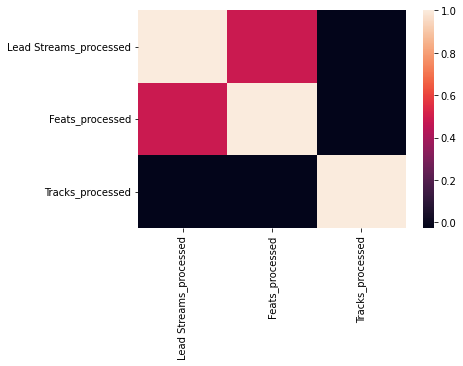

In [18]:
sns.heatmap(df.corr())

In [19]:
df.head().style.background_gradient(cmap = "inferno")

,Lead Streams_processed,Feats_processed,Tracks_processed
0,50162292808.00,19246513666.00,262.00
1,44369032140.00,5391990975.00,163.00
2,38153682361.00,2791278201.00,240.00
3,34767779741.00,4288903657.00,186.00
4,32596728109.00,424053296.00,323.00


In [20]:
df.describe().T.style.background_gradient(cmap = "viridis")

,count,mean,std,min,25%,50%,75%,max
Lead Streams_processed,1000.00,4291402641.14,4827223540.65,1420597420.00,1850498924.25,2613282547.00,4625016438.00,50162292808.00
Feats_processed,1000.00,861908543.15,1742020445.38,0.00,13723015.75,183307792.00,797751478.25,19246513666.00
Tracks_processed,1000.00,267.90,620.64,11.00,86.75,147.50,252.25,11475.00


In [21]:
df.columns

Index(['Lead Streams_processed', 'Feats_processed', 'Tracks_processed'], dtype='object')

Target Variable: Tracks_processed
CATS=====================
[]
CONTS=====================
['Lead Streams_processed', 'Feats_processed']
2
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Lead Streams_processed', 'Feats_processed']
Categorical variables that made the cut : []
Tabular Object size: 1001


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.21563518608026055, 'Adjusted R-Squared': -0.22797666005061856, 'RMSE': 925.026789098623, 'Time taken': 0.04818582534790039}
{'Model': 'BaggingRegressor', 'R-Squared': -0.04380145818213821, 'Adjusted R-Squared': -0.05439842730073874, 'RMSE': 857.1594723270578, 'Time taken': 0.04110431671142578}


  7%|▋         | 3/42 [00:00<00:01, 24.99it/s]

{'Model': 'BayesianRidge', 'R-Squared': -6.462911771309976e-06, 'Adjusted R-Squared': -0.010158812789048177, 'RMSE': 838.9847804404425, 'Time taken': 0.030379056930541992}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.33354405229971884, 'Adjusted R-Squared': -0.34708257059717806, 'RMSE': 968.8495961706337, 'Time taken': 0.014431238174438477}
{'Model': 'DummyRegressor', 'R-Squared': -6.692321798507095e-06, 'Adjusted R-Squared': -0.010159044528111227, 'RMSE': 838.98486, 'Time taken': 0.009178400039672852}
{'Model': 'ElasticNet', 'R-Squared': 0.000687187848596782, 'Adjusted R-Squared': -0.009458119888980931, 'RMSE': 838.6937, 'Time taken': 0.013113737106323242}
ElasticNetCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (1,1) we computed 648.458984375 but the user-supplied value was 648.4588012695312.
{'Model': 'ExtraTreeRegressor', 'R-Squared'

 21%|██▏       | 9/42 [00:00<00:01, 23.62it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.11598223612891578, 'Adjusted R-Squared': -0.1273120050236256, 'RMSE': 886.3011647645511, 'Time taken': 0.1891193389892578}
{'Model': 'GammaRegressor', 'R-Squared': 0.0006549394527439745, 'Adjusted R-Squared': -0.00949069567971561, 'RMSE': 838.7072830831542, 'Time taken': 0.015908241271972656}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -92476.09216631635, 'Adjusted R-Squared': -93414.94589389316, 'RMSE': 255134.8365118563, 'Time taken': 0.1409778594970703}


 29%|██▊       | 12/42 [00:00<00:01, 15.89it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': -0.025454073906184815, 'Adjusted R-Squared': -0.03586477516411568, 'RMSE': 849.5927282749673, 'Time taken': 0.14684367179870605}


 38%|███▊      | 16/42 [00:01<00:02, 11.81it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': -0.05646832671343627, 'Adjusted R-Squared': -0.06719389348210059, 'RMSE': 862.3447423453146, 'Time taken': 0.37899255752563477}
{'Model': 'HuberRegressor', 'R-Squared': -0.017611913345448427, 'Adjusted R-Squared': -0.02794299876012296, 'RMSE': 846.3378630214103, 'Time taken': 0.01577138900756836}
{'Model': 'KNeighborsRegressor', 'R-Squared': -0.0726218060179531, 'Adjusted R-Squared': -0.08351136750036892, 'RMSE': 868.9124, 'Time taken': 0.01071310043334961}
{'Model': 'KernelRidge', 'R-Squared': -0.10370142713670649, 'Adjusted R-Squared': -0.11490651776753613, 'RMSE': 881.4111, 'Time taken': 0.0902719497680664}
{'Model': 'Lars', 'R-Squared': 0.0007245948699977633, 'Adjusted R-Squared': -0.009420333100865319, 'RMSE': 838.67804, 'Time taken': 0.04848456382751465}


 43%|████▎     | 18/42 [00:01<00:01, 13.02it/s]

{'Model': 'LarsCV', 'R-Squared': -6.692321798507095e-06, 'Adjusted R-Squared': -0.010159044528111227, 'RMSE': 838.98486, 'Time taken': 0.059781551361083984}
{'Model': 'Lasso', 'R-Squared': 0.0007263010272566817, 'Adjusted R-Squared': -0.009418609622212859, 'RMSE': 838.6773, 'Time taken': 0.0148773193359375}
LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (1,1) we computed 648.458984375 but the user-supplied value was 648.4588012695312.
{'Model': 'LassoLars', 'R-Squared': -6.692321798507095e-06, 'Adjusted R-Squared': -0.010159044528111227, 'RMSE': 838.98486, 'Time taken': 0.010198831558227539}
{'Model': 'LassoLarsCV', 'R-Squared': -6.692321798507095e-06, 'Adjusted R-Squared': -0.010159044528111227, 'RMSE': 838.98486, 'Time taken': 0.015264272689819336}
{'Model': 'LassoLarsIC', 'R-Squared': -6.692321798507095e-06, 'Adjusted R-Squared': -0.01

 67%|██████▋   | 28/42 [00:02<00:01,  7.84it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.04439476000035181, 'Adjusted R-Squared': -0.05499775248766503, 'RMSE': 857.4031, 'Time taken': 1.3744549751281738}
{'Model': 'NuSVR', 'R-Squared': -0.013387508741790732, 'Adjusted R-Squared': -0.02367570680008302, 'RMSE': 844.579338115655, 'Time taken': 0.09927153587341309}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.0004664511231019519, 'Adjusted R-Squared': -0.00968109759646052, 'RMSE': 838.786374423844, 'Time taken': 0.02120208740234375}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.0007245764532984866, 'Adjusted R-Squared': -0.009420351704536145, 'RMSE': 838.6780609058836, 'Time taken': 0.016264677047729492}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.01529154685825751, 'Adjusted R-Squared': -0.02559907525275751, 'RMSE': 845.3723993006586, 'Time taken': 0.012583494186401367}
{'Model': 'PoissonRegressor', 'R-Squared': 0.0009808010303438142, 'Adjusted R-Squared': -0.009161525862749098, 'RMSE': 838.5705311382457

 79%|███████▊  | 33/42 [00:18<00:11,  1.27s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.020578985814080797, 'Adjusted R-Squared': -0.030940193791888726, 'RMSE': 847.5708075030782, 'Time taken': 15.626993656158447}
{'Model': 'RANSACRegressor', 'R-Squared': -0.04885943784436342, 'Adjusted R-Squared': -0.05950775701029598, 'RMSE': 859.2337, 'Time taken': 0.10043001174926758}


 83%|████████▎ | 35/42 [00:18<00:07,  1.00s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': -0.05760151912164302, 'Adjusted R-Squared': -0.06833859038176127, 'RMSE': 862.8071038702684, 'Time taken': 0.2716515064239502}
{'Model': 'Ridge', 'R-Squared': 0.0007246425708140602, 'Adjusted R-Squared': -0.009420284915776733, 'RMSE': 838.67804, 'Time taken': 0.010318279266357422}
{'Model': 'RidgeCV', 'R-Squared': 0.0007255023156572671, 'Adjusted R-Squared': -0.009419416442559392, 'RMSE': 838.6776723740488, 'Time taken': 0.010616302490234375}
{'Model': 'SGDRegressor', 'R-Squared': 0.0006881563217091546, 'Adjusted R-Squared': -0.009457141583654183, 'RMSE': 838.6933442233313, 'Time taken': 0.010894775390625}
{'Model': 'SVR', 'R-Squared': -0.02070608232849258, 'Adjusted R-Squared': -0.031068580626243847, 'RMSE': 847.6235814398635, 'Time taken': 0.050621747970581055}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.000724595479650425, 'Adjusted R-Squared': -0.009420332485023275, 'RMSE': 838.67804, 'Time taken': 0.010268688201904297}
{'M

100%|██████████| 42/42 [00:19<00:00,  2.13it/s]

{'Model': 'XGBRegressor', 'R-Squared': -0.1360148171737745, 'Adjusted R-Squared': -0.1475479625257925, 'RMSE': 894.22064, 'Time taken': 0.4855201244354248}
{'Model': 'LGBMRegressor', 'R-Squared': -0.042153843692182225, 'Adjusted R-Squared': -0.052734085760123284, 'RMSE': 856.4827027634647, 'Time taken': 0.15520930290222168}
Project: spotify-artist-stats
spotify-artist-stats
Target: Tracks_processed
Tracks_processed
Target Standard Deviation: 552.0327758789062
                               Adjusted R-Squared  R-Squared      RMSE  \
Model                                                                    
PoissonRegressor                            -0.01       0.00    838.57   
Lasso                                       -0.01       0.00    838.68   
RidgeCV                                     -0.01       0.00    838.68   
Ridge                                       -0.01       0.00    838.68   
LinearRegression                            -0.01       0.00    838.68   
TransformedTargetR

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,380846.468750,755462.562500,869.173523,00:00
1,376702.500000,736700.750000,858.312683,00:00
2,352404.312500,2064685.250000,1436.901367,00:00


Better model found at epoch 0 with _rmse value: 869.1735229492188.
Better model found at epoch 1 with _rmse value: 858.3126831054688.
No improvement since epoch 1: early stopping


,Lead Streams_processed,Feats_processed,Tracks_processed,Tracks_processed_pred
0,-0.52,-0.52,696.00,587.75
1,-0.19,-0.10,2051.00,203.02
2,-0.53,-0.37,33.00,554.63
3,-0.40,-0.53,63.00,506.23
4,1.04,8.51,476.00,693.70
5,-0.30,1.46,236.00,253.29
6,1.91,-0.50,350.00,187.25
7,0.08,0.07,572.00,59.48
8,0.57,1.99,113.00,190.26


<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0  276.00     186.50
1   75.00      80.68
2   45.00     176.40
3  316.00     191.31
4    0.00     274.78
XGBoost RMSE:  894.22064


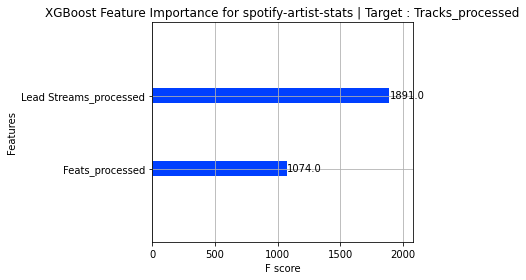

Target Variable: Feats_processed
CATS=====================
[]
CONTS=====================
['Lead Streams_processed', 'Tracks_processed']
2
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Lead Streams_processed', 'Tracks_processed']
Categorical variables that made the cut : []
Tabular Object size: 1001


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.08151525360386958, 'Adjusted R-Squared': 0.07219053536634534, 'RMSE': 1762741315.8465896, 'Time taken': 0.04558992385864258}
{'Model': 'BaggingRegressor', 'R-Squared': -0.10689949620957107, 'Adjusted R-Squared': -0.11813705454672419, 'RMSE': 1935114666.760694, 'Time taken': 0.040223121643066406}
{'Model': 'BayesianRidge', 'R-Squared': -0.0011430257550750778, 'Adjusted R-Squared': -0.01130691434142106, 'RMSE': 1840351048.030721, 'Time taken': 0.009873390197753906}


 10%|▉         | 4/42 [00:00<00:01, 36.86it/s]

{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.7460499601291506, 'Adjusted R-Squared': -0.7637763556634567, 'RMSE': 2430417830.8563213, 'Time taken': 0.012489080429077148}
{'Model': 'DummyRegressor', 'R-Squared': -0.0011430101480127686, 'Adjusted R-Squared': -0.011306898575911495, 'RMSE': 1840351000.0, 'Time taken': 0.010182857513427734}
{'Model': 'ElasticNet', 'R-Squared': 0.2909843894797899, 'Adjusted R-Squared': 0.28378626145420394, 'RMSE': 1548747000.0, 'Time taken': 0.0113372802734375}
ElasticNetCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (1,1) we computed 753.70947265625 but the user-supplied value was 753.7096557617188.
{'Model': 'ExtraTreeRegressor', 'R-Squared': -0.5095638162626623, 'Adjusted R-Squared': -0.5248893372399484, 'RMSE': 2259843417.8462687, 'Time taken': 0.013179779052734375}


 21%|██▏       | 9/42 [00:00<00:01, 22.90it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': -0.02167673025564376, 'Adjusted R-Squared': -0.03204908284707164, 'RMSE': 1859128295.0915685, 'Time taken': 0.17986369132995605}
GammaRegressor model failed to execute
Some value(s) of y are out of the valid range for family GammaDistribution
{'Model': 'GaussianProcessRegressor', 'R-Squared': -351.882004299671, 'Adjusted R-Squared': -355.464562718957, 'RMSE': 34551536524.17008, 'Time taken': 0.10105538368225098}


 29%|██▊       | 12/42 [00:00<00:01, 16.56it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.03067381599371799, 'Adjusted R-Squared': 0.020832941029187202, 'RMSE': 1810871283.6373625, 'Time taken': 0.16134381294250488}


 43%|████▎     | 18/42 [00:01<00:01, 14.91it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.051514148962312434, 'Adjusted R-Squared': 0.04188485098223438, 'RMSE': 1791298812.7272048, 'Time taken': 0.39144110679626465}
{'Model': 'HuberRegressor', 'R-Squared': -0.07910984146322675, 'Adjusted R-Squared': -0.09006527132579767, 'RMSE': 1910668907.508376, 'Time taken': 0.02033829689025879}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.17859180308170342, 'Adjusted R-Squared': 0.17025263356984255, 'RMSE': 1666986600.0, 'Time taken': 0.010866880416870117}
{'Model': 'KernelRidge', 'R-Squared': 0.1793968531362573, 'Adjusted R-Squared': 0.17106585672139696, 'RMSE': 1666169500.0, 'Time taken': 0.03535604476928711}
{'Model': 'Lars', 'R-Squared': 0.370668903458367, 'Adjusted R-Squared': 0.364279755270127, 'RMSE': 1459124000.0, 'Time taken': 0.021058320999145508}
{'Model': 'LarsCV', 'R-Squared': 0.36303987138097893, 'Adjusted R-Squared': 0.35657327109043047, 'RMSE': 1467941400.0, 'Time taken': 0.031533002853393555}
{'Model': 'Lasso'

 50%|█████     | 21/42 [00:01<00:01, 17.00it/s]

LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (1,1) we computed 753.70947265625 but the user-supplied value was 753.7096557617188.
{'Model': 'LassoLars', 'R-Squared': 0.3706689030330631, 'Adjusted R-Squared': 0.36427975484050534, 'RMSE': 1459124000.0, 'Time taken': 0.011398553848266602}
{'Model': 'LassoLarsCV', 'R-Squared': 0.36303987138097893, 'Adjusted R-Squared': 0.35657327109043047, 'RMSE': 1467941400.0, 'Time taken': 0.019216060638427734}
{'Model': 'LassoLarsIC', 'R-Squared': 0.3631870743329827, 'Adjusted R-Squared': 0.35672196848864746, 'RMSE': 1467771900.0, 'Time taken': 0.012483596801757812}
{'Model': 'LinearRegression', 'R-Squared': 0.3706688956579044, 'Adjusted R-Squared': 0.364279747390472, 'RMSE': 1459124000.0, 'Time taken': 0.011274576187133789}
{'Model': 'LinearSVR', 'R-Squared': -0.19455590621282326, 'Adjusted R-Squared': 

 69%|██████▉   | 29/42 [00:01<00:00, 19.09it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.19455623886217577, 'Adjusted R-Squared': -0.20668371336839075, 'RMSE': 2010277000.0, 'Time taken': 0.18651866912841797}
{'Model': 'NuSVR', 'R-Squared': -0.04878009634643132, 'Adjusted R-Squared': -0.05942761001492314, 'RMSE': 1883626657.609969, 'Time taken': 0.10341739654541016}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.37117901335785985, 'Adjusted R-Squared': 0.36479504395032547, 'RMSE': 1458532542.723126, 'Time taken': 0.015860557556152344}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.37117901335785985, 'Adjusted R-Squared': 0.36479504395032547, 'RMSE': 1458532542.723126, 'Time taken': 0.015121936798095703}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -0.19425037197329753, 'Adjusted R-Squared': -0.2063747412319097, 'RMSE': 2010019646.2488766, 'Time taken': 0.04925107955932617}
{'Model': 'PoissonRegressor', 'R-Squared': 0.4699677805058431, 'Adjusted R-Squared': 0.4645867427444811, 'RMSE': 1339071431.9256706, 'Tim

 76%|███████▌  | 32/42 [00:05<00:03,  2.65it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.18878534689365511, 'Adjusted R-Squared': -0.200854233664149, 'RMSE': 2005415333.8688407, 'Time taken': 3.630929708480835}
{'Model': 'RANSACRegressor', 'R-Squared': -0.17915400365731804, 'Adjusted R-Squared': -0.19112511029343304, 'RMSE': 1997275100.0, 'Time taken': 0.10101604461669922}


 95%|█████████▌| 40/42 [00:05<00:00,  5.33it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.017446339853666726, 'Adjusted R-Squared': 0.007471175791267326, 'RMSE': 1823185039.876654, 'Time taken': 0.27156615257263184}
{'Model': 'Ridge', 'R-Squared': 0.3704530754190767, 'Adjusted R-Squared': 0.3640617360832298, 'RMSE': 1459374200.0, 'Time taken': 0.012124300003051758}
{'Model': 'RidgeCV', 'R-Squared': 0.3685075316801586, 'Adjusted R-Squared': 0.36209644063122615, 'RMSE': 1461627472.2853794, 'Time taken': 0.010144472122192383}
{'Model': 'SGDRegressor', 'R-Squared': 0.37443543949007074, 'Adjusted R-Squared': 0.36808453024631504, 'RMSE': 1454751046.3500404, 'Time taken': 0.012006282806396484}
{'Model': 'SVR', 'R-Squared': -0.12028600744650353, 'Adjusted R-Squared': -0.13165946945103668, 'RMSE': 1946780849.7526689, 'Time taken': 0.05130887031555176}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.3706688956579044, 'Adjusted R-Squared': 0.364279747390472, 'RMSE': 1459124000.0, 'Time taken': 0.011210441589355469}
{'Model': 'Tw

100%|██████████| 42/42 [00:06<00:00,  6.54it/s]

{'Model': 'XGBRegressor', 'R-Squared': -0.2760566105973459, 'Adjusted R-Squared': -0.2890115000450346, 'RMSE': 2077722800.0, 'Time taken': 0.45786619186401367}
{'Model': 'LGBMRegressor', 'R-Squared': 0.06502632071811387, 'Adjusted R-Squared': 0.05553420214672411, 'RMSE': 1778493581.7533097, 'Time taken': 0.11600875854492188}
Project: spotify-artist-stats
spotify-artist-stats
Target: Feats_processed
Feats_processed
Target Standard Deviation: 1714707968.0
                               Adjusted R-Squared  R-Squared           RMSE  \
Model                                                                         
PoissonRegressor                             0.46       0.47  1339071431.93   
SGDRegressor                                 0.37       0.37  1454751046.35   
OrthogonalMatchingPursuitCV                  0.36       0.37  1458532542.72   
OrthogonalMatchingPursuit                    0.36       0.37  1458532542.72   
Lasso                                        0.36       0.37  145912

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,3793279106821390336.000000,4041214031082553344.000000,2010276992.000000,00:00
1,3726360080375873536.000000,4041212931570925568.000000,2010276864.000000,00:00
2,3701346740599783424.000000,4041206334501158912.000000,2010275072.000000,00:00
3,3726211096550309888.000000,4041145036727910400.000000,2010259968.000000,00:00
4,3671502421609152512.000000,4041161529402327040.000000,2010264064.000000,00:00


Better model found at epoch 0 with _rmse value: 2010276992.0.
Better model found at epoch 1 with _rmse value: 2010276864.0.
Better model found at epoch 2 with _rmse value: 2010275072.0.
Better model found at epoch 3 with _rmse value: 2010259968.0.
No improvement since epoch 3: early stopping


,Lead Streams_processed,Tracks_processed,Feats_processed,Feats_processed_pred
0,-0.57,-0.31,18238192.00,7790.42
1,-0.37,0.22,1274578048.00,4383.62
2,0.10,-0.05,3762124.00,3335.14
3,-0.55,-0.35,1164003712.00,8048.58
4,-0.50,-0.36,861833.00,8100.23
5,-0.58,-0.17,645180352.00,6918.04
6,-0.34,0.45,352247744.00,3138.61
7,-0.46,-0.31,797904640.00,7783.21
8,0.17,0.07,1335247.00,3269.82


<Figure size 432x288 with 0 Axes>

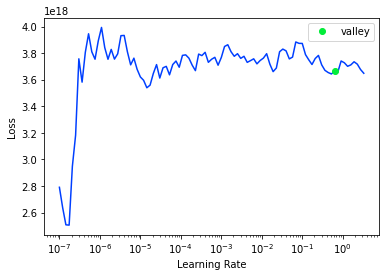

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
         actual     predicted
0 5360563200.00 2017273984.00
1 1957856256.00  279611936.00
2  578240000.00  416015008.00
3 3118921728.00  207483648.00
4  371487744.00  493770272.00
XGBoost RMSE:  2077722800.0


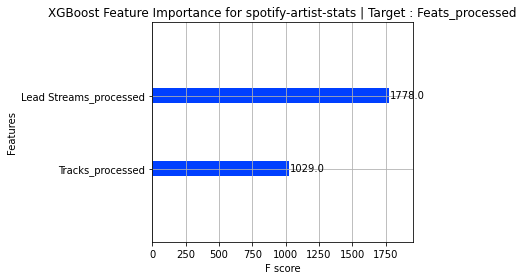

<Figure size 432x288 with 0 Axes>

In [22]:
target = ''
target_str = ''
#The column closest to the end isPARAM_DIR the target variable that can be represented as a float is the target variable
targets = []
#Loop through every possible target column (Continuous)
for i in range(len(df.columns)-1, 0, -1):
    try:
        df[df.columns[i]] = df[df.columns[i]].apply(pd.to_numeric, errors='coerce').dropna()
        target = df.columns[i]
        target_str = target.replace('/', '-')
    except:
        continue
    print(f'Target Variable: {target}')
    #Will be determined by the file name


    #===================================================================================================

    #Create project config files if they don't exist.
    if not os.path.exists(param_dir):
        #create param_dir
        os.makedirs(PARAM_DIR)
    if not os.path.exists(f'{PARAM_DIR}/cats.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/cats.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/conts.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/conts.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/cols_to_delete.txt'):
        with open(f'{PARAM_DIR}/cols_to_delete.txt', 'w') as f:
            f.write('')

    df = df.drop_duplicates()
    if SHUFFLE_DATA:
        df = df.sample(frac=1).reset_index(drop=True)

    # workaround for fastai/pytorch bug where bool is treated as object and thus erroring out.
    for n in df:
        if pd.api.types.is_bool_dtype(df[n]):
            df[n] = df[n].astype('uint8')

    with open(f'{PARAM_DIR}/cols_to_delete.txt', 'r') as f:
        cols_to_delete = f.read().splitlines()
    for col in cols_to_delete:
        try:
            del(df[col])
        except:
            pass
    #try to fill in missing values now, otherwise FastAI will do it for us later
    try:
        df = df.fillna(0)
    except:
        pass
    #print missing values
    #print(df.isna().sum().sort_values(ascending=False))
    #shrink df as much as possible
    df = df_shrink(df)


    #print types inside of df
    #print(df.dtypes)


    #Auto detect categorical and continuous variables
    #==============================================================================
    likely_cat = {}
    for var in df.columns:
        likely_cat[var] = 1.*df[var].nunique()/df[var].count() < 0.05 #or some other threshold

    cats = [var for var in df.columns if likely_cat[var]]
    conts = [var for var in df.columns if not likely_cat[var]]

    #remove target from lists
    try:
        conts.remove(target)
        cats.remove(target)
    except:
        pass
    #Convert target to float
    df[target] = df[target].apply(pd.to_numeric, errors='coerce').dropna()

    print('CATS=====================')
    print(cats)
    print('CONTS=====================')
    print(conts)

    #Populate categorical and continuous lists
    #==============================================================================

    if VARIABLE_FILES == True:
        with open(f'{PARAM_DIR}/cats.txt', 'r') as f:
            cats = f.read().splitlines()

        with open(f'{PARAM_DIR}/conts.txt', 'r') as f:
            conts = f.read().splitlines()

    #==============================================================================

    #==============================================================================
    procs = [Categorify, FillMissing, Normalize]
    #print(df.describe().T)
    df = df[0:SAMPLE_COUNT]
    splits = RandomSplitter()(range_of(df))

    print((len(cats)) + len(conts))
    #conts = []

    #Convert cont variables to floats
    #==============================================================================

    #Convert cont variables to floats
    #==============================================================================

    for var in conts:
        try:
            df[var] = df[var].apply(pd.to_numeric, errors='coerce').dropna()
        except:
            print(f'Could not convert {var} to float.')
            pass

    #==============================================================================

    #Experimental logic to add columns one-by-one to find a breakpoint
    #==============================================================================
    if ENABLE_BREAKPOINT == True:
        temp_procs = [Categorify, FillMissing]
        print('Looping through continuous variables to find breakpoint')
        cont_list = []
        for cont in conts:
            focus_cont = cont
            cont_list.append(cont)
            #print(focus_cont)
            try:
                to = TabularPandas(df, procs=procs, cat_names=cats, cont_names=cont_list, y_names=target, y_block=RegressionBlock(), splits=splits)
                del(to)
            except:
                print('Error with ', focus_cont)
                #remove focus_cont from list
                cont_list.remove(focus_cont)
                #traceback.print_exc()
                continue
        #convert all continuous variables to floats
        for var in cont_list:
            try:
                df[var] = df[var].apply(pd.to_numeric, errors='coerce').dropna()
            except:
                print(f'Could not convert {var} to float.')
                cont_list.remove(var)
                if CONVERT_TO_CAT == True:
                    cats.append(var)
                pass
        print(f'Continuous variables that made the cut : {cont_list}')
        print(f'Categorical variables that made the cut : {cats}')
        #shrink df as much as possible
        df = df_shrink(df)
        #print(df.dtypes)

    #==============================================================================

    #Creating tabular object + quick preprocessing
    #==============================================================================
    to = None
    if REGRESSOR == True:
        try:
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
    else:
        try:
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)

    #print(dir(to))
    #print(to.xs)
    dls = to.dataloaders()
    print(f'Tabular Object size: {len(to)}')
    try:
        dls.one_batch()
    except:
        print(f'problem with getting one batch of {PROJECT_NAME}')
    #==============================================================================

    #Extracting train and test sets from tabular object
    #==============================================================================

    X_train, y_train = to.train.xs, to.train.ys.values.ravel()
    X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

    #Make sure target isn't in independent columns
    if target in X_train and target in X_test:
        del(X_train[target])
        del(X_test[target])
    #create dataframe from X_train and y_train
    #export tabular object to csv
    pd.DataFrame(X_train).to_csv(f'{PARAM_DIR}/X_train_{target_str}.csv', index=False)
    pd.DataFrame(X_test).to_csv(f'{PARAM_DIR}/X_test_{target_str}.csv', index=False)
    pd.DataFrame(y_train).to_csv(f'{PARAM_DIR}/y_train_{target_str}.csv', index=False)
    pd.DataFrame(y_test).to_csv(f'{PARAM_DIR}/y_test_{target_str}.csv', index=False)

    #==============================================================================

    #==============================================================================

    #Ready for model selection!

    if REGRESSOR == True:
        try:
            reg = LazyRegressor(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = reg.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            target_std = y_train.std()
            print(f'Target Standard Deviation: {target_std}')
            print(models)
            models['project'] = PROJECT_NAME
            models['target'] = target
            models['target_std'] = target_std
            #rename index of 
            models.to_csv(f'{PARAM_DIR}/regression_results_{target_str}.csv', mode='a', header=True, index=True)
        except:
            print('Issue during lazypredict analysis')
    else:
        #TODO: remove this
        try:
            clf = LazyClassifier(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = clf.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            print(f'Target Standard Deviation: {y_train.std()}')
            print(models)
            models.to_csv(f'{PARAM_DIR}/classification_results.csv', mode='a', header=False)
        except:
            print('Issue during lazypredict analysis')

    model_name = 'tabnet'

    # FastAI + pre-trained TabNet
    #==============================================================================
    learn = None
    i = 0
    while True:
        try:
            del learn
        except:
            pass
        try:
            learn = 0
            model = TabNetModel(get_emb_sz(to), len(to.cont_names), dls.c, n_d=64, n_a=64, n_steps=5, virtual_batch_size=256)
            # save the best model so far, determined by early stopping
            cbs = [SaveModelCallback(monitor='_rmse', comp=np.less, fname=f'{model_name}_{PROJECT_NAME}_{target_str}_best'), EarlyStoppingCallback()]
            learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=rmse, cbs=cbs)
            #learn = get_learner(to)
            if(learn != 0):
                break
            if i > 50:
                break
        except:
            i += 1
            print('Error in FastAI TabNet')
            traceback.print_exc()
            continue
    try:
        #display learning rate finder results
        x = learn.lr_find()
    except:
        pass
    if AUTO_ADJUST_LEARNING_RATE == True:
        FASTAI_LEARNING_RATE = x.valley
    print(f'LEARNING RATE: {FASTAI_LEARNING_RATE}')
    try:
        if i < 50:
            learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
            plt.figure(figsize=(10, 10))
            try:
                ax = learn.show_results()
                plt.show(block=True)
            except:
                print('Could not show results')
                pass
    except:
        print('Could not fit model')
        traceback.print_exc()
        pass

    #==============================================================================

    #fit an xgboost model
    #==============================================================================
    if REGRESSOR == True:
        xgb = XGBRegressor()
    else:
        xgb = XGBClassifier()
    try:
        xgb = XGBRegressor()
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        print('XGBoost Predictions vs Actual==========')
        print(pd.DataFrame({'actual': y_test, 'predicted': y_pred}).head())
        print('XGBoost RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
        #save feature importance plot to file
        plot_importance(xgb)
        plt.title(f'XGBoost Feature Importance for {PROJECT_NAME} | Target : {target}', wrap=True)
        plt.tight_layout()
        plt.show()
        plt.savefig(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.png')
        fi_df = pd.DataFrame([xgb.get_booster().get_score()]).T
        fi_df.columns = ['importance']
        #create a column based off the index called feature
        fi_df['feature'] = fi_df.index
        #create a dataframe of feature importance
        fi_df = fi_df[['feature', 'importance']]
        fi_df.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv', index=False)
        #xgb_fi = pd.DataFrame(xgb.feature_importances_, index=X_train.columns, columns=['importance'])
        #xgb_fi.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv')
        #print('XGBoost AUC: ', roc_auc_score(y_test, y_pred))
    except:
        traceback.print_exc()
        print('XGBoost failed')

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Overall Feature Importance**</div>

                  feature  importance
0  Lead Streams_processed     1778.00
1        Tracks_processed     1029.00
0  Lead Streams_processed     1891.00
1         Feats_processed     1074.00


<AxesSubplot:title={'center':'XGBoost Overall Feature Importance'}, xlabel='feature'>

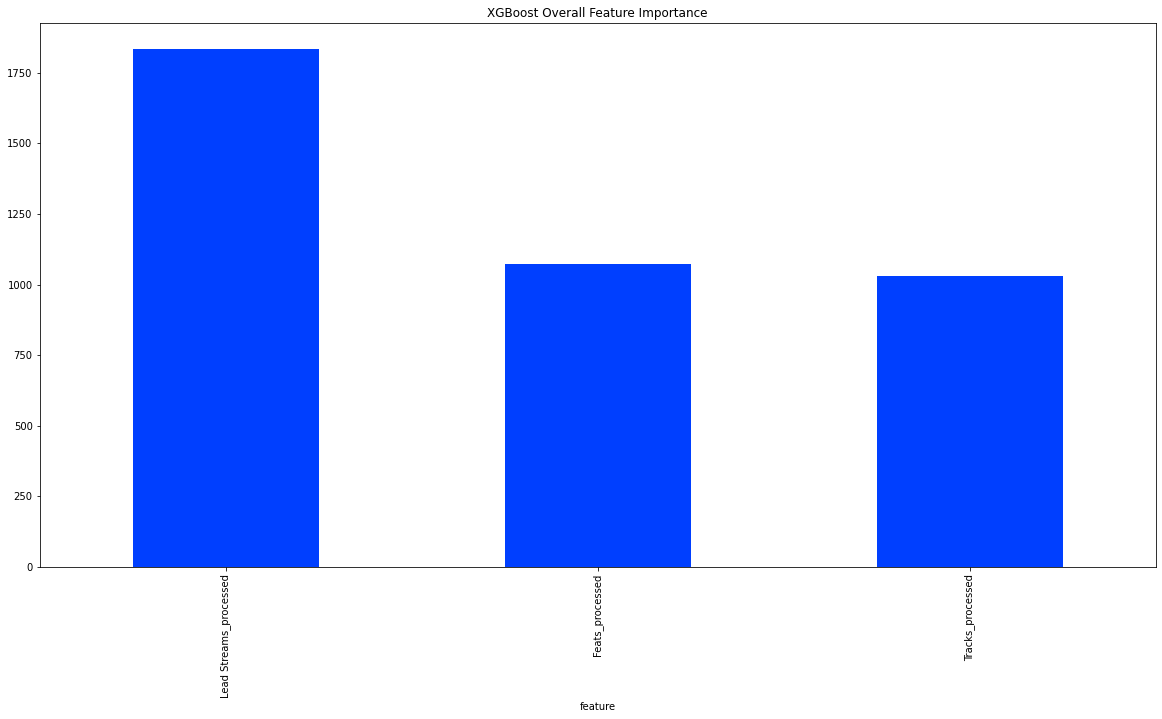

In [23]:
out_dir = f'./{PROJECT_NAME}'
xgb_feature_importance_csvs = []

for file in os.listdir(out_dir):
    if 'xgb_feature_importance' in file and '.csv' in file:
        xgb_feature_importance_csvs.append(pd.read_csv(os.path.join(out_dir, file)))

xgb_feature_importance = pd.concat(xgb_feature_importance_csvs,axis=0)
xgb_feature_importance.rename(columns={'Unnamed: 0': 'feature'}, inplace=True)
print(xgb_feature_importance.head())
xgb_feature_importance.groupby('feature')['importance'].mean().sort_values(ascending=False).plot(kind='bar', title='XGBoost Overall Feature Importance', figsize=(20, 10))

In [24]:
df.isna().sum()

Lead Streams_processed    0
Feats_processed           0
Tracks_processed          0
dtype: int64

# **To Be Continued...**